# Install library

In [ ]:
!pip install panda lxml bs4 httpx backtesting yfinance pandas_ta scipy rich matplotlib mplfinance keras tensorflow pymc3

# import library

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
import concurrent.futures
from datetime import datetime
import glob
import warnings
from rich.progress import track
warnings.filterwarnings("ignore")
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas_ta as taPanda
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import Counter
import httpx

# Utilities Function

In [ ]:
def make_api_request(api_endpoint, params):
    with httpx.Client() as client:
        # Make the GET request to the API
        response = client.get(api_endpoint, params=params)
        if response.status_code == 200:
            return response.json()
        print("Error: Failed to retrieve data from API")
        return None

In [ ]:
BASE_URL_FMP = "https://financialmodelingprep.com/api/v3"
BASE_URL_BINANCE = "https://fapi.binance.com/fapi/v1/"

FMP_API_KEY = "17c09553207c6d6e7bab10003e604aa8"
BINANCE_API_KEY = ""

In [ ]:
def get_historical_price_full_crypto(symbol):
    api_endpoint = f"{BASE_URL_FMP}/historical-price-full/crypto/{symbol}"
    params = {"apikey": FMP_API_KEY}
    return make_api_request(api_endpoint, params)


def get_historical_price_full_stock(symbol):
    api_endpoint = f"{BASE_URL_FMP}/historical-price-full/{symbol}"
    params = {"apikey": FMP_API_KEY}

    return make_api_request(api_endpoint, params)

def get_SP500():
    api_endpoint = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    data = pd.read_html(api_endpoint)
    return list(data[0]['Symbol'])

def get_all_crypto():
    """
    All possible crypto symbols
    """
    return [
        "BTCUSD",
        "ETHUSD",
        "LTCUSD",
        "BCHUSD",
        "XRPUSD",
        "EOSUSD",
        "XLMUSD",
        "TRXUSD",
        "ETCUSD",
        "DASHUSD",
        "ZECUSD",
        "XTZUSD",
        "XMRUSD",
        "ADAUSD",
        "NEOUSD",
        "XEMUSD",
        "VETUSD",
        "DOGEUSD",
        "OMGUSD",
        "ZRXUSD",
        "BATUSD"
        "USDTUSD",
        "LINKUSD",
        "BTTUSD",
        "BNBUSD",
        "ONTUSD",
        "QTUMUSD",
        "ALGOUSD",
        "ZILUSD",
        "ICXUSD",
        "KNCUSD",
        "ZENUSD",
        "THETAUSD",
        "IOSTUSD",
        "ATOMUSD",
        "MKRUSD",
        "COMPUSD",
        "YFIUSD",
        "SUSHIUSD",
        "SNXUSD",
        "UMAUSD",
        "BALUSD",
        "AAVEUSD",
        "UNIUSD",
        "RENBTCUSD",
        "RENUSD",
        "CRVUSD",
        "SXPUSD",
        "KSMUSD",
        "OXTUSD",
        "DGBUSD",
        "LRCUSD",
        "WAVESUSD",
        "NMRUSD",
        "STORJUSD",
        "KAVAUSD",
        "RLCUSD",
        "BANDUSD",
        "SCUSD",
        "ENJUSD",
    ]

def get_financial_statements_lists():
    api_endpoint = f"{BASE_URL_FMP}/financial-statement-symbol-lists"
    params = {"apikey": FMP_API_KEY}
    return make_api_request(api_endpoint, params)

# Split the Data into Train and Test

In [ ]:
stock_symbol = "AAPL"
stock_prices = get_historical_price_full_stock(stock_symbol)

data = pd.DataFrame(stock_prices['historical'])

In [ ]:
data

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2024-01-26,194.27,194.7600,191.9400,192.42,192.42,44566855,41708329,-1.85,-0.952280,193.12,"January 26, 24",-0.009523
1,2024-01-25,195.22,196.2675,193.1125,194.17,194.17,54822126,54822100,-1.05,-0.537850,194.73,"January 25, 24",-0.005378
2,2024-01-24,195.42,196.3800,194.3400,194.50,194.50,53631316,53631300,-0.92,-0.470780,195.21,"January 24, 24",-0.004708
3,2024-01-23,195.02,195.7500,193.8299,195.18,195.18,42355590,42355600,0.16,0.082043,194.82,"January 23, 24",0.000820
4,2024-01-22,192.30,195.3300,192.2600,193.89,193.89,60131852,60133900,1.59,0.826830,193.99,"January 22, 24",0.008268
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2019-02-01,41.74,42.2400,41.4800,41.63,39.96,130672400,130672400,-0.11,-0.263540,41.79,"February 01, 19",-0.002635
1255,2019-01-31,41.53,42.2500,41.1400,41.61,39.94,162958400,162958400,0.08,0.192630,41.67,"January 31, 19",0.001926
1256,2019-01-30,40.81,41.5400,40.0600,41.31,39.65,244439200,244439200,0.50,1.230000,40.97,"January 30, 19",0.012300
1257,2019-01-29,39.06,39.5300,38.5300,38.67,37.12,166348800,166348800,-0.39,-0.998460,38.91,"January 29, 19",-0.009985


In [ ]:
january_2023_index = data[(data['date'] < '2023-01-01')].index
january_2023_index

Index([ 268,  269,  270,  271,  272,  273,  274,  275,  276,  277,
       ...
       1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258],
      dtype='int64', length=991)

In [ ]:
prices_before_january_2023 = data.loc[january_2023_index]
prices_before_january_2023

# Assuming prices_before_january_2023 is your DataFrame
prices_before_january_2023 = prices_before_january_2023.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'  # Only if you have a volume column
})

# Drop any additional columns that are not required
required_columns = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
prices_before_january_2023 = prices_before_january_2023[required_columns]

# sort by date ascending
prices_before_january_2023 = prices_before_january_2023.sort_values(by=['date'], ascending=True)

prices_before_january_2023

,date,Open,High,Low,Close,Volume
1258,2019-01-28,38.95,39.08,38.42,39.08,104768400
1257,2019-01-29,39.06,39.53,38.53,38.67,166348800
1256,2019-01-30,40.81,41.54,40.06,41.31,244439200
1255,2019-01-31,41.53,42.25,41.14,41.61,162958400
1254,2019-02-01,41.74,42.24,41.48,41.63,130672400
...,...,...,...,...,...,...
272,2022-12-23,130.92,132.42,129.64,131.86,63814900
271,2022-12-27,131.38,131.41,128.72,130.03,69007800
270,2022-12-28,129.67,131.03,125.87,126.04,85438400
269,2022-12-29,127.99,130.48,127.73,129.61,75703700


In [ ]:
prices_after_january_2023 = data.drop(january_2023_index)
prices_after_january_2023

# Assuming prices_after_january_2023 is your DataFrame
prices_after_january_2023 = prices_after_january_2023.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'  # Only if you have a volume column
})

# Drop any additional columns that are not required
required_columns = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
prices_after_january_2023 = prices_after_january_2023[required_columns]

# sort by date ascending
prices_after_january_2023 = prices_after_january_2023.sort_values(by=['date'], ascending=True)

prices_after_january_2023

,date,Open,High,Low,Close,Volume
267,2023-01-03,130.28,130.9000,124.1700,125.07,112117500
266,2023-01-04,126.89,128.6600,125.0800,126.36,89113600
265,2023-01-05,127.13,127.7700,124.7600,125.02,80962700
264,2023-01-06,126.01,130.2900,124.8900,129.62,87754700
263,2023-01-09,130.47,133.4100,129.8900,130.15,70790800
...,...,...,...,...,...,...
4,2024-01-22,192.30,195.3300,192.2600,193.89,60131852
3,2024-01-23,195.02,195.7500,193.8299,195.18,42355590
2,2024-01-24,195.42,196.3800,194.3400,194.50,53631316
1,2024-01-25,195.22,196.2675,193.1125,194.17,54822126


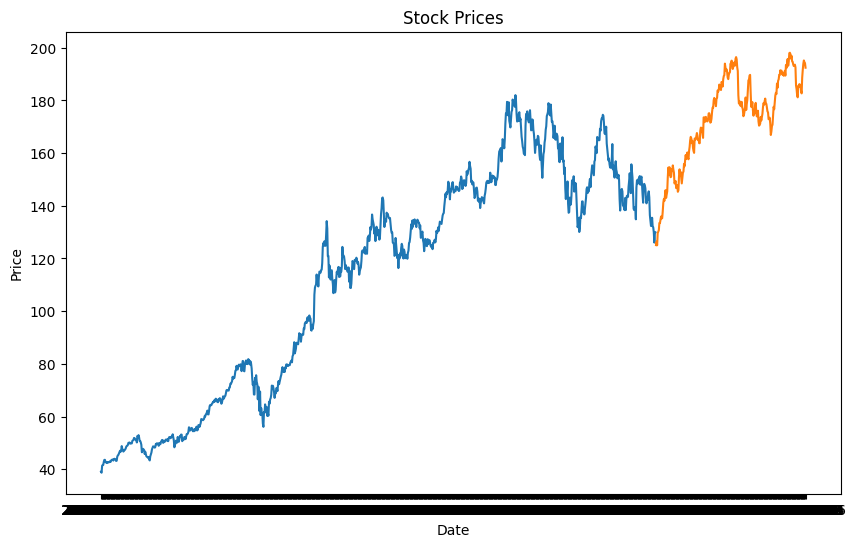

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(prices_before_january_2023['date'], prices_before_january_2023['Close'])
plt.plot(prices_after_january_2023['date'], prices_after_january_2023['Close'])
plt.show()

# Monte Carlo Simulation

In [ ]:
def monte_carlo_simulation(data, days, iterations):
    # Convert to numpy array if data is a pandas Series
    if isinstance(data, pd.Series):
        data = data.to_numpy()

    # Ensure data is a numpy array
    if not isinstance(data, np.ndarray):
        raise TypeError("Data must be a numpy array or pandas Series")

    # Calculate log returns
    log_returns = np.log(data[1:] / data[:-1])
    mean = np.mean(log_returns)
    variance = np.var(log_returns)
    drift = mean - (0.5 * variance)
    daily_volatility = np.std(log_returns)

    future_prices = np.zeros((days, iterations))
    current_price = data[-1]
    for t in range(days):
        shocks = drift + daily_volatility * norm.ppf(np.random.rand(iterations))
        future_prices[t] = current_price * np.exp(shocks)
        current_price = future_prices[t]
    return future_prices


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random

def monte_carlo_simulation_with_roulette(data, days, iterations, roulette_chance=0.05, extreme_factor=3):
    # Initial setup remains the same
    if isinstance(data, pd.Series):
        data = data.to_numpy()
    
    if not isinstance(data, np.ndarray):
        raise TypeError("Data must be a numpy array or pandas Series")

    log_returns = np.log(data[1:] / data[:-1])
    mean = np.mean(log_returns)
    variance = np.var(log_returns)
    drift = mean - (0.5 * variance)
    daily_volatility = np.std(log_returns)

    future_prices = np.zeros((days, iterations))
    current_price = data[-1]

    # Modified simulation with Russian Roulette
    for t in range(days):
        # Standard Monte Carlo step
        shocks = drift + daily_volatility * norm.ppf(np.random.rand(iterations))
        
        # Russian Roulette: Randomly applying an extreme shock
        if random.random() < roulette_chance:
            # Apply a large positive or negative shock
            extreme_shock = extreme_factor * daily_volatility * np.random.choice([-1, 1], size=iterations)
            shocks += extreme_shock
        
        future_prices[t] = current_price * np.exp(shocks)
        current_price = future_prices[t]

    return future_prices


# Markov Chain Simulation Transition Matrix

In [ ]:
bins = list(range(0, 210, 10)) + [np.inf]
strata = pd.cut(prices_before_january_2023['Close'], bins=bins)

transition_matrix = pd.crosstab(pd.Series(strata[:-1], name='Current'),
                                pd.Series(strata[1:], name='Next'),
                                normalize='index')

# Markov Chain Simulation

In [ ]:
def markov_chain_simulation(transition_matrix, start_state, days):
    states = list(transition_matrix.columns)
    current_state = start_state
    state_sequence = [current_state]

    for _ in range(days):
        current_state = np.random.choice(states, p=transition_matrix.loc[current_state])
        state_sequence.append(current_state)

    return state_sequence

#  MCMCStrategy

In [ ]:
class MCMCStrategy(Strategy):
    stop_loss_percentage = 0.05  # Dynamic based on volatility
    take_profit_percentage = 0.10  # Dynamic based on Monte Carlo prediction

    def init(self):
        # Initializing indicators and simulations
        self.is_long = False
        self.mc_iterations = 1000
        self.start_state = 0

        self.mc_prices = monte_carlo_simulation(self.data.Close, len(self.data), self.mc_iterations)
        self.markov_states = markov_chain_simulation(transition_matrix, self.start_state, len(self.data))

    def next(self):
        if not self.position:
            # Buy condition: Bullish state and EMA(20) above EMA(50)
            if self.markov_states[-1] == 0:
                self.buy()
                self.is_long = True
                self.entry_price = self.data.Close[-1]
        else:
            if self.is_long:
                # Dynamic stop-loss and take-profit
                stop_loss = self.entry_price * (1 - self.stop_loss_percentage)
                take_profit = self.mc_prices[-1, np.random.randint(self.mc_iterations)]

                if self.data.Close[-1] <= stop_loss or self.data.Close[-1] >= take_profit:
                    self.sell()
                    self.is_long = False

# Create two separate Backtest instances for before and after January 2023

In [ ]:
bt_mcmc_before_january = Backtest(prices_before_january_2023, MCMCStrategy,
                             cash=10000, commission=.002,
                             exclusive_orders=True)

bt_mcmc_after_january = Backtest(prices_after_january_2023, MCMCStrategy,
                            cash=10000, commission=.002,
                            exclusive_orders=True)

In [ ]:
output_mcmc_before_january = bt_mcmc_before_january.run()

In [ ]:
output_mcmc_before_january

In [ ]:
output_mcmc_after_january = bt_mcmc_after_january.run()

In [ ]:
output_mcmc_after_january

In [ ]:
bt_mcmc_after_january.plot()

# Run BUYHOLD backtests

In [ ]:
class BuyAndHoldStrategy(Strategy):
    def init(self):
        self.is_long = False

    def next(self):
        # Buy and Hold Strategy
        if not self.is_long:
            self.buy()
            self.is_long = True

In [ ]:

bt_before_january = Backtest(prices_before_january_2023, BuyAndHoldStrategy, cash=10000, commission=.002, exclusive_orders=True)
bt_after_january = Backtest(prices_after_january_2023, BuyAndHoldStrategy, cash=10000, commission=.002, exclusive_orders=True)

In [ ]:
before_after_january = bt_after_january.run()

In [ ]:
output_after_january = bt_after_january.run()

## Access performance metrics for BUYHOLD backtests

In [ ]:

print("Performance Metrics Before January 2023:")
print(output_before_january)
print("\nPerformance Metrics After January 2023:")
print(output_after_january)

In [ ]:
# Define a function to run a backtest and plot the results
def run_backtest_and_plot(prices, strategy_class, title):
    bt = Backtest(prices, strategy_class, cash=10000, commission=.002, exclusive_orders=True)
    output = bt.run()
    bt.plot(title=title)
    return output

In [ ]:
def buy_and_hold_backtest(prices):
    simulation_days = len(prices)
    mc_iterations = 100
    start_state = 0  # Initial state (can be changed)
    mc_prices = monte_carlo_simulation(prices, simulation_days, mc_iterations)
    markov_states = markov_chain_simulation(transition_matrix, start_state, simulation_days)

    # Simple "Buy and Hold" Strategy Backtest
    final_prices = mc_prices[-1, :]  # Prices at the end of the simulation
    initial_price = prices[-1]  # Initial price
    portfolio_values = final_prices - initial_price  # Portfolio values

    # Calculate strategy returns
    strategy_returns = portfolio_values / initial_price
    return strategy_returns

def run_backtest_and_plot(prices, strategy_class, title):
    bt = Backtest(prices, strategy_class, cash=10000, commission=.002, exclusive_orders=True)
    output = bt.run()
    bt.plot(title=title)
    return output

# Perform "Buy and Hold" backtest for prices before January 2023
strategy_returns_before_january = buy_and_hold_backtest(prices_before_january_2023)

# Perform "Buy and Hold" backtest for prices after January 2023
strategy_returns_after_january = buy_and_hold_backtest(prices_after_january_2023)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(strategy_returns_before_january, label="Before January 2023")
plt.plot(strategy_returns_after_january, label="After January 2023")
plt.title('Buy and Hold Strategy Returns')
plt.xlabel('Simulation Iterations')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Run and plot the MCMC-based backtests
output_before_january_mcmc = run_backtest_and_plot(prices_before_january_2023, MCMCStrategy, "MCMC Strategy Before January 2023")
output_after_january_mcmc = run_backtest_and_plot(prices_after_january_2023, MCMCStrategy, "MCMC Strategy After January 2023")

# Access performance metrics for both MCMC-based backtests
print("Performance Metrics for MCMC Strategy Before January 2023:")
print(output_before_january_mcmc)
print("\nPerformance Metrics for MCMC Strategy After January 2023:")
print(output_after_january_mcmc)